# Iterative Workflow in LangGraph

In [67]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model
from langchain.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
import operator

load_dotenv()

True

In [68]:
generator_llm = init_chat_model("gpt-5-nano")
evaluator_llm = init_chat_model("gpt-5")
optimizer_llm = init_chat_model("gpt-5-mini")

In [69]:
# Doing this to have structured response

from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "need_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="Feedback for the tweet.")

In [70]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [71]:
# State - Defining State by creating a class

class TweetState(TypedDict):

    topic : str
    tweet : str

    evaluation : Literal["approved", "need_improvement"]
    feedback : str
    iteration : int
    max_iteration : int
    
    tweet_history : Annotated[list[str], operator.add]
    tweet_feedback_history : Annotated[list[str], operator.add]

In [72]:
# Defining the generate function
def generate_tweet(state: TweetState, model = generator_llm):

    topic = state['topic']

    # Prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X Influencer."),
        HumanMessage(content=f"""
        Write a short, original, and hilarious tweet on the topic: {state['topic']}.

        Rules:
        - Do NOT use question answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Use simple, day to day english.
        - This is version {state['iteration'] + 1}.
        """)
    ]

    # Generate response from the LLM 
    response = generator_llm.invoke(messages).content

    return { "tweet" : response , "tweet_history" : [response] }

In [73]:
# Defining the e function
def evaluate_tweet(state: TweetState, model = evaluator_llm):

    # Draft the prompt
    messages = [
            SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
            HumanMessage(content=f"""
            Evaluate the following tweet:
            
            Tweet: "{state['tweet']}"
            
            Use the criteria below to evaluate the tweet:
            
            1. Originality – Is this fresh, or have you seen it a hundred times before?  
            2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness – Is it short, sharp, and scroll-stopping?  
            4. Virality Potential – Would people retweet or share it?  
            5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?
            
            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)
            
            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"  
            - feedback: One paragraph explaining the strengths and weaknesses 
            """)
            ]


    # Structured Output
    response = structured_evaluator_llm.invoke(messages)

    return { "evaluation" : response.evaluation, "feedback" : response.feedback, "tweet_feedback_history" :  [response.feedback]}

In [74]:
# Defining the optimizer function
def optimize_tweet(state: TweetState, model = optimizer_llm):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"
            
            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}
            
            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """)
            ]
    
    # Using Optimizer LLM
    response = optimizer_llm.invoke(messages).content

    # This monitor number of iteration in the agent loop 
    iteration = state['iteration'] + 1

    return { "tweet" : response , "iteration" : iteration , "tweet_history" : [response]}

In [75]:
# Defining Conditional Check Function

def conditional_check(state: TweetState):

    if state['evaluation'] == "approved" or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [76]:
# Defining Graph
tweet_graph = StateGraph(TweetState)

# Adding Nodes
tweet_graph.add_node("generate", generate_tweet)
tweet_graph.add_node("evaluate", evaluate_tweet) # Node Name, Function Name
tweet_graph.add_node("optimizer", optimize_tweet)

# Adding Edges
tweet_graph.add_edge(START, "generate")
tweet_graph.add_edge("generate", "evaluate")
tweet_graph.add_conditional_edges('evaluate', conditional_check, {'approved': END, 'needs_improvement': 'optimizer'})
tweet_graph.add_edge("optimizer", "evaluate")

# Compiling the graph
tweet_workflow = tweet_graph.compile()

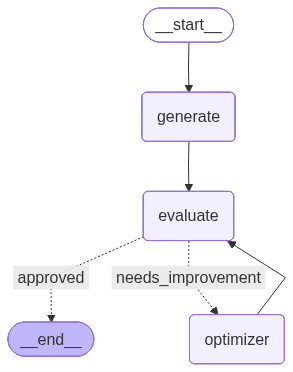

In [77]:
tweet_workflow

In [78]:
initial_state = {
    "topic" : "Indian Civic Sense",
    "iteration" : 1, 
    "max_iteration" : 5
}

final_state = tweet_workflow.invoke(initial_state)

final_state

{'topic': 'Indian Civic Sense',
 'tweet': 'Civic sense in India: sidewalks moonlight as wedding halls, tea stalls and parking lots. Rules aren’t broken — they’re rescheduled between chai breaks.',
 'evaluation': 'approved',
 'feedback': 'Wry, well-formed, and under 280, this lands a neat turn of phrase with “rescheduled between chai breaks,” which gives a familiar India-civic trope some fresh gloss. It’s more smirk than laugh-out-loud, and the “Civic sense in India:” preface reads a bit preachy and slows the scroll. The list is slightly wordy, but the imagery is clear and shareable; expect decent engagement (relatable + reply bait) even if the premise isn’t groundbreaking. Tightening the opener and trimming the list would boost punch.',
 'iteration': 2,
 'max_iteration': 5,
 'tweet_history': ['Indian civic sense is a sport: we queue for buses, ignore lane lines, potholes double as speed bumps, honks are our morning playlist, and red lights are just polite suggestions we debate over cha